# FrEIAを用いたFlowの構築と学習

このチュートリアルでは，Invertible Neural Networks; INNを構築するためのフレームワークFrEIAを用いて，Flowを構築し，学習するためのサンプルを提供します．

## 1. 2D-toy DatasetにおけるFlowの構築と学習

まずは，2D-toy Datasetにどのようなデータが含まれているかを確認します．

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.datasets import make_moons

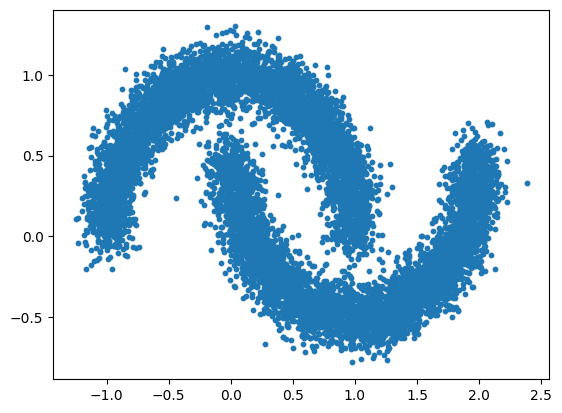

In [2]:
X, _ = make_moons(n_samples=10000, noise=0.1)
inputs = torch.from_numpy(X.astype(np.float32))
plt.scatter(inputs[:, 0], inputs[:, 1], s=10)
plt.show()

入力テンソルの形状は，(2,)です．次に簡単なFlowを構築します．

In [ ]:
import torch
import torch.nn as nn

from FrEIA import framework as Ff
from FrEIA import modules as Fm

# subnetworkを定義
def subnet_fc(dims_in, dims_out):
    return nn.Sequential(
        nn.Linear(dims_in, 512),
        nn.ReLU(),
        nn.Linear(512, dims_out)
    )

# 今回は単純なAffine Couplingを順番に適用します．
# Sequential APIを用いてFlowを構築します．

input_dims = (2, )  # バッチサイズを除いた入力テンソルの形状

# SequenceINNを初期化
inn = Ff.SequenceINN(*input_dims)

# append()メソッドで追加
for k in range(8):
    inn.append(Fm.AllInOneBlock, subnet_constructor=subnet_fc)

In [4]:
# 可逆なFlowを構築できているか確認
x = torch.rand(8, 2)
z, jac = inn(x)
x_inv, jac_inv = inn(z, rev=True)

assert torch.max(torch.abs(x - x_inv)) < 1e-5
assert torch.max(torch.abs(jac + jac_inv)) < 1e-5

それでは，Flowを学習させていきます．SequenceINNはtorch.nn.moduleを継承しているため，通常のNNの訓練と同じように学習させることができます．

In [5]:
dataloader = torch.utils.data.DataLoader(inputs, batch_size=32)

In [6]:
# 損失関数を定義
def likelihood(z: torch.Tensor, jac: torch.Tensor) -> torch.Tensor:
    """
    Args:
        z: 潜在変数z0, 多変量標準ガウス分布に従うと仮定, 形状は(B, D, ...), Dは潜在変数の次元．
        jac: 各変数変換における対数ヤコビ行列式の総和, 形状は(B, )
    Returns:
        対数尤度log(p(X))
    """
    # なぜこうなるのかについては，多変量ガウス分布の式を参照
    loss = 0.5*torch.sum(z**2, 1) - jac
    loss = loss.mean() / z.shape[1]
    return loss

それでは学習していきましょう．学習には長くて1時間ほどかかります．

In [10]:
import tqdm

# 学習するためのデバイスを設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# モデルをGPU(CPU)に移す
inn.to(device)
optimizer = torch.optim.Adam(inn.parameters(), lr=1e-4)

for epoch in range(100):
    for batch in tqdm.tqdm(dataloader):
        # 推論し，損失を計算
        x = batch.to(device)
        z, jac = inn(x)
        loss = likelihood(z, jac)

        # 勾配を初期化
        optimizer.zero_grad()

        # 勾配を計算
        loss.backward()

        # 重みを更新
        optimizer.step()

 66%|██████▋   | 208/313 [00:03<00:01, 61.08it/s]


KeyboardInterrupt: 

それでは学習したFlowを使って，潜在変数の分布からダブルムーン分布を生成できるかを試してみましょう．

In [ ]:
# 多変量標準ガウス分布からサンプリング
loc = torch.zeros(2)
cov_mat = torch.eye(2, 2)
test = torch.distributions.MultivariateNormal(loc=loc, covariance_matrix=cov_mat).sample(sample_shape=(5000,))

plt.scatter(test[:, 0], test[:, 1], s=5)
plt.show()

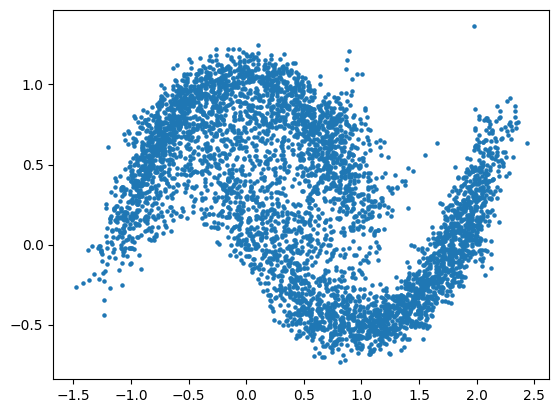

In [11]:
# 学習したFlowにより，ダブルムーン分布に逆変換
inn.to('cpu')

outputs, _ = inn(test, rev=True)
outputs = outputs.detach().numpy()
plt.scatter(outputs[:, 0], outputs[:, 1], s=5)
plt.show()

## 2. MNISTにおけるConditional Flowの構築

MNISTを用いて，各数字ラベル（1-hotベクトル）により条件付けられた分布を学習するFlowを構築してみましょう．この実装はFrEIAの開発者でもあるArdizzone氏により提案された[cINN](https://arxiv.org/abs/1907.02392)を参考にしています．気になった方はぜひ原論文も読んでみてください．

まずは手書き文字データセットMINISTを読み込み，その中のいくつかを表示してみます．

In [189]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

mnist_dataset = MNIST(root='./data', download=True, transform=ToTensor())
dataloader = torch.utils.data.DataLoader(mnist_dataset, batch_size=32, shuffle=True)

In [190]:
batch = next(iter(dataloader))
img_batch = batch[0]
label_batch = batch[1]

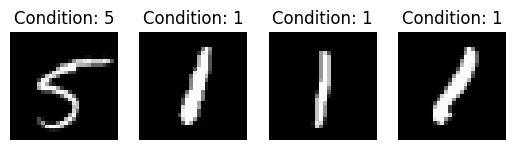

<Figure size 640x480 with 0 Axes>

In [191]:
fig, ax = plt.subplots(1, 4)
for idx in range(4):
    img, label = img_batch[idx], label_batch[idx]
    img = img.permute([1, 2, 0])
    ax[idx].imshow(img, cmap='gray')
    ax[idx].set_title(f'Condition: {label}')
    ax[idx].set_axis_off()
plt.show()
plt.tight_layout()

In [195]:
class OneHot:
    def __init__(self, size: int):
        self.size = size

    def __call__(self, label: int):
        onehot = torch.zeros(self.size)
        onehot[label] = 1
        return onehot

In [196]:
# 数字を表すラベルは1-hotベクトルとして入力する.
from torchvision import transforms

transform = transforms.Compose([
    ToTensor(),
    torch.nn.Flatten(),
    torch.squeeze
])
target_transform = transforms.Compose([
    OneHot(10)
])
mnist_dataset = MNIST(root='./data', download=True, transform=transform, target_transform=target_transform
)
dataloader = torch.utils.data.DataLoader(mnist_dataset, batch_size=32, shuffle=True)

In [197]:
label_batch = next(iter(dataloader))[1]
label_batch[0]

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

条件入力を受け取るFlowを構築します．

In [226]:
input = Ff.InputNode(28*28, name='Input')

def subnet(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, 512), nn.ReLU(),
                         nn.Linear(512, dims_out))

In [227]:
cond_dims = (10, )
input_dims = (28*28, )
cinn = Ff.SequenceINN(*input_dims)

for k in range(12):
    cinn.append(Fm.AllInOneBlock, cond=0, cond_shape=cond_dims, subnet_constructor=subnet)

batch = next(iter(dataloader))
x = batch[0]
c = batch[1]

z, jac = cinn(x, c=[c])
x_rev, jac_rev = cinn(z, c=[c], rev=True)

# 可逆なFlowが構築できているかをチェック
assert torch.max(torch.abs(x- x_rev)) < 1e-5
assert torch.max(torch.abs(jac + jac_rev)) < 1e-5

それでは学習を進めていきます．

In [271]:
cinn.to(device)
optimizer = torch.optim.Adam(cinn.parameters(), lr=1e-4)

for epoch in range(100):
    print(f'Epoch{epoch+1}\n')
    for data, label in tqdm.tqdm(dataloader):
        data = data.to(device)
        label = label.to(device)

        z, jac = cinn(data, c=[label])

        loss = likelihood(z, jac)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Epoch1



100%|██████████| 1875/1875 [01:04<00:00, 28.91it/s]


Epoch2



100%|██████████| 1875/1875 [01:04<00:00, 28.99it/s]


Epoch3



100%|██████████| 1875/1875 [01:05<00:00, 28.60it/s]


Epoch4



100%|██████████| 1875/1875 [01:05<00:00, 28.75it/s]


Epoch5



100%|██████████| 1875/1875 [01:03<00:00, 29.39it/s]


Epoch6



100%|██████████| 1875/1875 [01:03<00:00, 29.63it/s]


Epoch7



100%|██████████| 1875/1875 [01:02<00:00, 29.86it/s]


Epoch8



100%|██████████| 1875/1875 [01:03<00:00, 29.73it/s]


Epoch9



100%|██████████| 1875/1875 [01:03<00:00, 29.76it/s]


Epoch10



100%|██████████| 1875/1875 [01:02<00:00, 29.84it/s]


Epoch11



100%|██████████| 1875/1875 [01:03<00:00, 29.65it/s]


Epoch12



100%|██████████| 1875/1875 [01:03<00:00, 29.67it/s]


Epoch13



100%|██████████| 1875/1875 [01:03<00:00, 29.64it/s]


Epoch14



100%|██████████| 1875/1875 [01:03<00:00, 29.70it/s]


Epoch15



100%|██████████| 1875/1875 [01:03<00:00, 29.70it/s]


Epoch16



100%|██████████| 1875/1875 [01:02<00:00, 29.77it/s]


Epoch17



100%|██████████| 1875/1875 [01:03<00:00, 29.76it/s]


Epoch18



100%|██████████| 1875/1875 [01:02<00:00, 29.83it/s]


Epoch19



100%|██████████| 1875/1875 [01:03<00:00, 29.75it/s]


Epoch20



100%|██████████| 1875/1875 [01:02<00:00, 29.78it/s]


Epoch21



100%|██████████| 1875/1875 [01:02<00:00, 29.76it/s]


Epoch22



100%|██████████| 1875/1875 [01:03<00:00, 29.75it/s]


Epoch23



100%|██████████| 1875/1875 [01:02<00:00, 29.77it/s]


Epoch24



100%|██████████| 1875/1875 [01:03<00:00, 29.73it/s]


Epoch25



100%|██████████| 1875/1875 [01:02<00:00, 29.78it/s]


Epoch26



100%|██████████| 1875/1875 [01:02<00:00, 29.79it/s]


Epoch27



100%|██████████| 1875/1875 [01:02<00:00, 29.84it/s]


Epoch28



100%|██████████| 1875/1875 [01:02<00:00, 29.89it/s]


Epoch29



100%|██████████| 1875/1875 [01:02<00:00, 29.81it/s]


Epoch30



100%|██████████| 1875/1875 [01:02<00:00, 29.85it/s]


Epoch31



100%|██████████| 1875/1875 [01:03<00:00, 29.71it/s]


Epoch32



100%|██████████| 1875/1875 [01:02<00:00, 29.79it/s]


Epoch33



100%|██████████| 1875/1875 [01:02<00:00, 29.86it/s]


Epoch34



100%|██████████| 1875/1875 [01:02<00:00, 29.87it/s]


Epoch35



100%|██████████| 1875/1875 [01:02<00:00, 29.91it/s]


Epoch36



100%|██████████| 1875/1875 [01:03<00:00, 29.74it/s]


Epoch37



100%|██████████| 1875/1875 [01:02<00:00, 29.82it/s]


Epoch38



100%|██████████| 1875/1875 [01:02<00:00, 29.82it/s]


Epoch39



100%|██████████| 1875/1875 [01:02<00:00, 29.88it/s]


Epoch40



100%|██████████| 1875/1875 [01:02<00:00, 29.80it/s]


Epoch41



100%|██████████| 1875/1875 [01:03<00:00, 29.70it/s]


Epoch42



100%|██████████| 1875/1875 [01:02<00:00, 29.82it/s]


Epoch43



100%|██████████| 1875/1875 [01:03<00:00, 29.70it/s]


Epoch44



100%|██████████| 1875/1875 [01:02<00:00, 29.79it/s]


Epoch45



100%|██████████| 1875/1875 [01:02<00:00, 29.91it/s]


Epoch46



100%|██████████| 1875/1875 [01:02<00:00, 29.77it/s]


Epoch47



100%|██████████| 1875/1875 [01:02<00:00, 29.77it/s]


Epoch48



100%|██████████| 1875/1875 [01:03<00:00, 29.74it/s]


Epoch49



100%|██████████| 1875/1875 [01:02<00:00, 29.80it/s]


Epoch50



100%|██████████| 1875/1875 [01:02<00:00, 29.82it/s]


Epoch51



100%|██████████| 1875/1875 [01:02<00:00, 29.79it/s]


Epoch52



100%|██████████| 1875/1875 [01:02<00:00, 29.88it/s]


Epoch53



100%|██████████| 1875/1875 [01:03<00:00, 29.72it/s]


Epoch54



100%|██████████| 1875/1875 [01:02<00:00, 29.80it/s]


Epoch55



100%|██████████| 1875/1875 [01:02<00:00, 29.85it/s]


Epoch56



100%|██████████| 1875/1875 [01:02<00:00, 29.94it/s]


Epoch57



100%|██████████| 1875/1875 [01:02<00:00, 29.93it/s]


Epoch58



100%|██████████| 1875/1875 [01:02<00:00, 29.87it/s]


Epoch59



100%|██████████| 1875/1875 [01:02<00:00, 29.92it/s]


Epoch60



100%|██████████| 1875/1875 [01:03<00:00, 29.66it/s]


Epoch61



100%|██████████| 1875/1875 [01:02<00:00, 29.96it/s]


Epoch62



100%|██████████| 1875/1875 [01:02<00:00, 29.98it/s]


Epoch63



100%|██████████| 1875/1875 [01:02<00:00, 29.82it/s]


Epoch64



100%|██████████| 1875/1875 [01:02<00:00, 29.94it/s]


Epoch65



100%|██████████| 1875/1875 [01:02<00:00, 29.79it/s]


Epoch66



100%|██████████| 1875/1875 [01:02<00:00, 29.92it/s]


Epoch67



100%|██████████| 1875/1875 [01:02<00:00, 30.07it/s]


Epoch68



100%|██████████| 1875/1875 [01:02<00:00, 29.87it/s]


Epoch69



100%|██████████| 1875/1875 [01:02<00:00, 29.96it/s]


Epoch70



100%|██████████| 1875/1875 [01:02<00:00, 29.96it/s]


Epoch71



100%|██████████| 1875/1875 [01:02<00:00, 29.95it/s]


Epoch72



100%|██████████| 1875/1875 [01:02<00:00, 30.11it/s]


Epoch73



100%|██████████| 1875/1875 [01:02<00:00, 29.92it/s]


Epoch74



100%|██████████| 1875/1875 [01:02<00:00, 29.86it/s]


Epoch75



100%|██████████| 1875/1875 [01:02<00:00, 29.97it/s]


Epoch76



100%|██████████| 1875/1875 [01:02<00:00, 30.07it/s]


Epoch77



100%|██████████| 1875/1875 [01:02<00:00, 30.01it/s]


Epoch78



100%|██████████| 1875/1875 [01:02<00:00, 30.00it/s]


Epoch79



100%|██████████| 1875/1875 [01:02<00:00, 30.01it/s]


Epoch80



100%|██████████| 1875/1875 [01:02<00:00, 30.03it/s]


Epoch81



100%|██████████| 1875/1875 [01:02<00:00, 29.91it/s]


Epoch82



100%|██████████| 1875/1875 [01:02<00:00, 29.94it/s]


Epoch83



100%|██████████| 1875/1875 [01:02<00:00, 30.13it/s]


Epoch84



100%|██████████| 1875/1875 [01:04<00:00, 29.24it/s]


Epoch85



  2%|▏         | 40/1875 [00:01<01:07, 27.06it/s]


KeyboardInterrupt: 

In [278]:
# 学習させたcINNによって生成される画像を見てみる．
loc = torch.zeros(size=input_dims)
cov_mat = torch.eye(n=input_dims[0])
mvn = torch.distributions.MultivariateNormal(loc, cov_mat)
z = mvn.sample([1,])
onehot = torch.zeros((1, 10))
onehot[:, 5] = 1

cinn.to('cpu')
rev_img, _ = cinn(z, c=[onehot], rev=True)

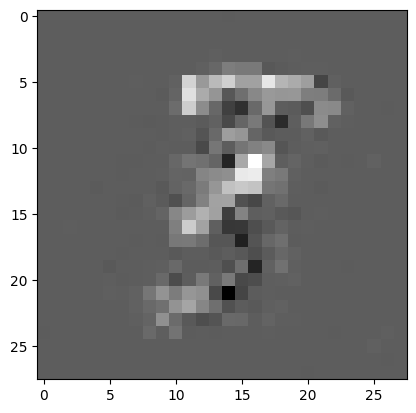

In [279]:
img = torch.reshape(rev_img, shape=[28, 28, 1]).detach().numpy()
plt.imshow(img, cmap='gray')